C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The number of classes is: 2 
 The number of channels is 1.
The class_names are {'0': 'normal', '1': 'pneumonia'}
{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: C:\Users\Theodora\.medmnist\

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


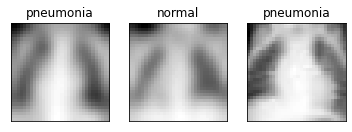

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

from ConvNet import ConvNet
from Model_LeNet import LeNet


from dataset import train_dataset, test_dataset, train_loader, test_loader, task, n_channels, n_classes

In [12]:
epochs = 30
lr = 0.001
num_workers = 2



In [13]:
ConvNet(n_channels, n_classes)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): MyDropout()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [14]:
def save_model(model):
    '''
    Function to save the trained model 
    '''
   
    if model.__class__.__name__ == 'LeNet':
        torch.save(model.state_dict(), '../outputs/pneumonia_lenet.ckpt')
    else:
        torch.save(model.state_dict(), '../outputs/pneumonia_convnet.ckpt')
        

In [15]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0
    for i, (image, labels) in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        #image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        
        # Calculate the loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds==labels).sum().item()
        # Backpropagation
        loss.backward()
        #Update teh weights
        optimizer.step()
        
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss/counter
    epoch_acc = 100.*(train_running_correct/ len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [16]:
if __name__ == '__main__':
    # Criterion
    if task == 'multi-label, binary-class':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
        
    # model selection
    model = ConvNet(n_channels, n_classes)  # LeNet accyracy: 89.075
    print(model.__class__.__name__ )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)
    
    # Lists to keep track of losses and accuracies
    train_loss = []
    train_acc = []
    # Starting the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        
        print(f"Training Loss: {train_epoch_loss:.3f}, training_acc: {train_epoch_acc:.3f}")
        print ('='*50)
        
    #Save the trained model weights
    save_model(model)

ConvNet
[INFO]: Epoch 1 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 81.97it/s] 


Training Loss: 0.604, training_acc: 74.108
[INFO]: Epoch 2 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 78.95it/s] 


Training Loss: 0.579, training_acc: 74.214
[INFO]: Epoch 3 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 74.14it/s]


Training Loss: 0.573, training_acc: 74.214
[INFO]: Epoch 4 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 78.62it/s]


Training Loss: 0.568, training_acc: 74.214
[INFO]: Epoch 5 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 81.92it/s] 


Training Loss: 0.565, training_acc: 74.214
[INFO]: Epoch 6 of 30
Training


100%|██████████| 148/148 [00:02<00:00, 72.75it/s]


Training Loss: 0.555, training_acc: 74.214
[INFO]: Epoch 7 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 82.18it/s] 


Training Loss: 0.532, training_acc: 74.405
[INFO]: Epoch 8 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 76.51it/s]


Training Loss: 0.499, training_acc: 75.743
[INFO]: Epoch 9 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 74.06it/s]


Training Loss: 0.450, training_acc: 79.184
[INFO]: Epoch 10 of 30
Training


100%|██████████| 148/148 [00:02<00:00, 68.40it/s]


Training Loss: 0.410, training_acc: 82.647
[INFO]: Epoch 11 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 79.58it/s] 


Training Loss: 0.363, training_acc: 84.303
[INFO]: Epoch 12 of 30
Training


100%|██████████| 148/148 [00:02<00:00, 67.59it/s]


Training Loss: 0.337, training_acc: 86.088
[INFO]: Epoch 13 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 81.43it/s] 


Training Loss: 0.320, training_acc: 86.534
[INFO]: Epoch 14 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 77.38it/s]


Training Loss: 0.294, training_acc: 87.234
[INFO]: Epoch 15 of 30
Training


100%|██████████| 148/148 [00:02<00:00, 72.04it/s]


Training Loss: 0.278, training_acc: 88.764
[INFO]: Epoch 16 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 80.94it/s] 


Training Loss: 0.270, training_acc: 88.976
[INFO]: Epoch 17 of 30
Training


100%|██████████| 148/148 [00:02<00:00, 73.14it/s]


Training Loss: 0.259, training_acc: 89.528
[INFO]: Epoch 18 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 77.69it/s] 


Training Loss: 0.245, training_acc: 90.017
[INFO]: Epoch 19 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 79.51it/s]


Training Loss: 0.243, training_acc: 90.081
[INFO]: Epoch 20 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 80.72it/s]


Training Loss: 0.243, training_acc: 90.442
[INFO]: Epoch 21 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 80.06it/s] 


Training Loss: 0.225, training_acc: 90.994
[INFO]: Epoch 22 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 81.32it/s] 


Training Loss: 0.227, training_acc: 90.675
[INFO]: Epoch 23 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 80.68it/s] 


Training Loss: 0.221, training_acc: 91.546
[INFO]: Epoch 24 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 76.46it/s]


Training Loss: 0.213, training_acc: 91.504
[INFO]: Epoch 25 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 76.88it/s]


Training Loss: 0.209, training_acc: 91.737
[INFO]: Epoch 26 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 81.96it/s] 


Training Loss: 0.205, training_acc: 91.589
[INFO]: Epoch 27 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 78.60it/s] 


Training Loss: 0.220, training_acc: 91.504
[INFO]: Epoch 28 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 77.92it/s]


Training Loss: 0.200, training_acc: 92.353
[INFO]: Epoch 29 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 79.45it/s]


Training Loss: 0.210, training_acc: 92.120
[INFO]: Epoch 30 of 30
Training


100%|██████████| 148/148 [00:01<00:00, 77.15it/s] 

Training Loss: 0.206, training_acc: 92.268
